In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score





%store -r model_df

# pd.set_option('display.width', 200)  # Set a large width
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

with open("model_df.pkl", "rb") as f:
    model_df = pickle.load(f)

print(model_df.head())  # Verify the DataFrame is loaded



no stored variable or alias model_df
   price  low_price  mid_price  high_price  carat  carat_color_interaction  \
0    337          1          0           0   0.22                     1.10   
1   2757          0          1           0   0.86                     4.30   
2   2759          0          1           0   0.96                     3.84   
3   2762          0          1           0   0.70                     2.80   
4   2762          0          1           0   0.70                     2.80   

   carat_clarity_interaction  quality_composite  carat_quality_interaction  \
0                       0.66                3.2                      0.704   
1                       0.86                2.4                      2.064   
2                       0.96                2.0                      1.920   
3                       2.10                2.8                      1.960   
4                       2.10                2.8                      1.960   

       volume  
0   36.42

Dropped 'volume' to address Multicollinearity

The correlation matrix shows high correlations (e.g., carat vs. volume: 1.0, carat_quality_interaction vs. carat_clarity_interaction: 0.9). 



In [51]:

target = ['price']
features = ['carat', 'carat_color_interaction', 'carat_clarity_interaction',
       'quality_composite', 'carat_quality_interaction']


X = model_df[features]
y = model_df[target]


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Random Forest

In [53]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Gradient Boosting

In [54]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)


/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


### XGBoost

In [55]:


xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.1,
                              max_depth=5,
                             random_state=42,
                             objective='reg:squarederror')

# xgb_model = xgb.XGBRegressor(n_estimators=500,
#                              learning_rate=0.01,
#                               max_depth=7,
#                              random_state=42,
#                              subsample = 0.8,
#                              colsample_bytree = 1.0,
#                              objective='reg:squarederror')
# ('colsample_bytree': 1.0, 'learning_rate': 0.01, 
#  'max_depth': 7, 
#  'n_estimators': 500, 
#  'subsample': 0.8)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)


### Evaluate Models

In [56]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"🔹 {model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    print("-" * 40)

# Evaluate all models
evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, gb_preds, "Gradient Boosting")
evaluate_model(y_test, xgb_preds, "XGBoost")


🔹 Random Forest Performance:
RMSE: 594.99
MAE: 304.85
R²: 0.98
----------------------------------------
🔹 Gradient Boosting Performance:
RMSE: 651.92
MAE: 359.01
R²: 0.97
----------------------------------------
🔹 XGBoost Performance:
RMSE: 600.49
MAE: 313.56
R²: 0.98
----------------------------------------


### Ensemble Approach (Combine Random Forest & XGBoost)

This blend the prediction of Random Forest and XGBoost

In [57]:
#Define the Ensemble Model Class

class EnsembleModel:
    def __init__(self, rf_model, xgb_model):
        self.rf_model = rf_model
        self.xgb_model = xgb_model

    def fit(self, X, y):
        """Train both models on the given data."""
        self.rf_model.fit(X, y)
        self.xgb_model.fit(X, y)    

    def predict(self, X):
        rf_preds = self.rf_model.predict(X)
        xgb_preds = self.xgb_model.predict(X)
        ensemble_preds = (rf_preds + xgb_preds) / 2  # Averaging predictions
        return ensemble_preds



In [58]:
# Define your models first
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)


# Create the ensemble model
ensemble_model = EnsembleModel(rf_model = rf_model , xgb_model=xgb_model)

# Train the ensemble model on the entire training dataset
ensemble_model.fit(X_train, y_train.squeeze())

# Get predictions on test data
ensemble_pred = ensemble_model.predict(X_test)

rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae_ensemble = mean_absolute_error(y_test, ensemble_pred)
r2_ensemble = r2_score(y_test, ensemble_pred)

print(f"🔹 Ensemble Model Performance:")
print(f"RMSE: {rmse_ensemble:.2f}")
print(f"MAE: {mae_ensemble:.2f}")
print(f"Test R²: {r2_ensemble:.2f}")


ensemble_pred = pd.Series(ensemble_pred, index=y_test.index)

# Ensure y_test is a Pandas Series
low_price_mask = y_test < 1000  # Should be a boolean Series

# Convert to a NumPy array or ensure it remains a Series
low_price_mask = low_price_mask.squeeze()  # Ensures it's not a DataFrame

# Apply the mask correctly
y_test_low = y_test[low_price_mask]
ensemble_pred_low = ensemble_pred.loc[low_price_mask]  # Use `.loc[]` to avoid indexing issues

# Compute MAE for low-priced diamonds
mae_low = mean_absolute_error(y_test_low, ensemble_pred_low)
print(f"MAE for Low-Price Diamonds (< $1000): {mae_low:.2f}")


🔹 Ensemble Model Performance:
RMSE: 579.44
MAE: 297.80
Test R²: 0.98
MAE for Low-Price Diamonds (< $1000): 76.50


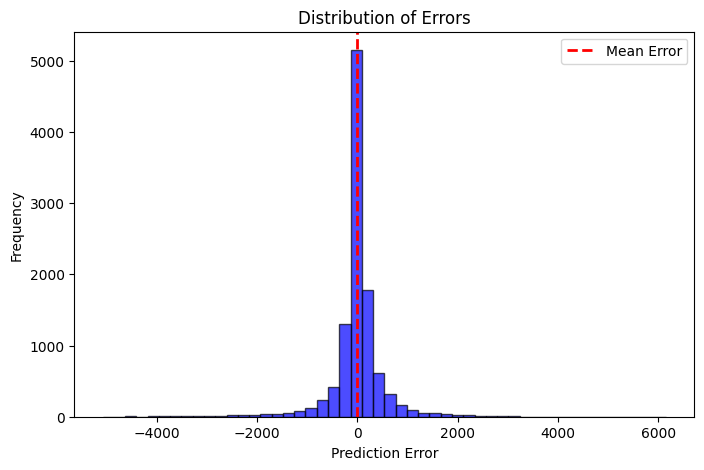

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_test and ensemble_pred are 1D arrays
y_test_values = np.array(y_test).reshape(-1)
ensemble_pred_values = np.array(ensemble_pred).reshape(-1)

# Compute errors
errors = y_test_values - ensemble_pred_values

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(errors.mean(), color='red', linestyle='dashed', linewidth=2, label="Mean Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Errors")
plt.legend()
plt.show()


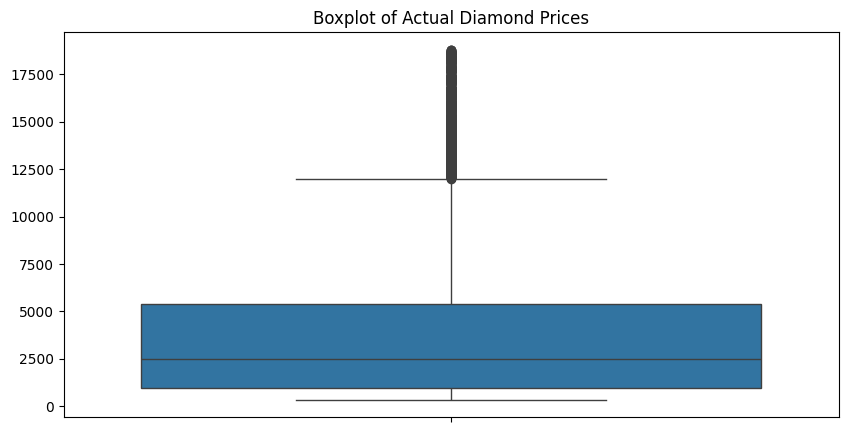

In [60]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.boxplot(y=y_test_values)
plt.title("Boxplot of Actual Diamond Prices")
plt.show()


## Actual vs Predicted Prices

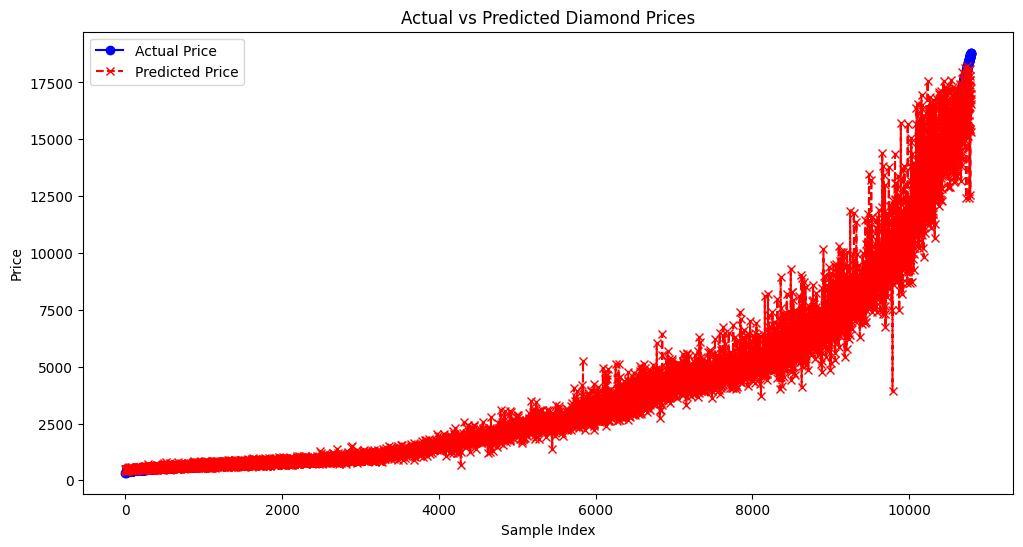

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure predictions and labels are 1D
ensemble_pred = ensemble_pred.to_numpy().reshape(-1)
y_test_values = y_test.to_numpy().reshape(-1)

# Sort values for smooth visualization
sorted_idx = np.argsort(y_test_values)

plt.figure(figsize=(12, 6))
plt.plot(y_test_values[sorted_idx], label="Actual Price", linestyle="-", marker="o", color="blue")
plt.plot(ensemble_pred[sorted_idx], label="Predicted Price", linestyle="--", marker="x", color="red")

plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Diamond Prices")
plt.legend()
plt.show()


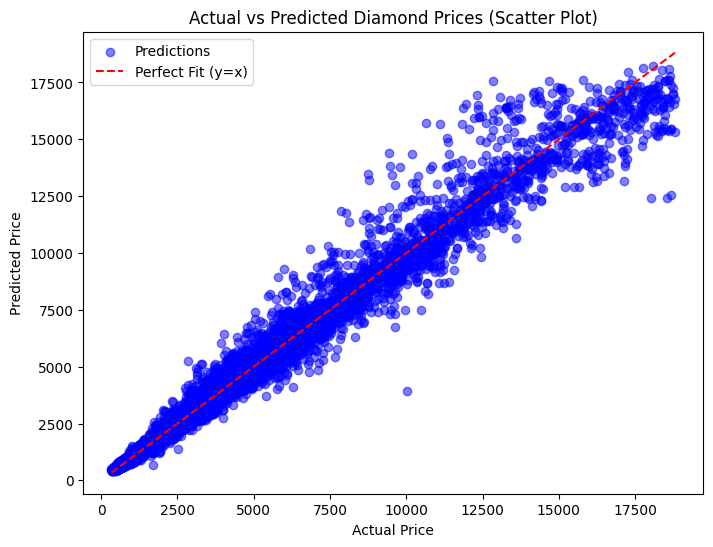

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_values, ensemble_pred, alpha=0.5, color="blue", label="Predictions")

# Plot a perfect prediction reference line (y = x)
plt.plot([min(y_test_values), max(y_test_values)], [min(y_test_values), max(y_test_values)], 
         linestyle="--", color="red", label="Perfect Fit (y=x)")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Diamond Prices (Scatter Plot)")
plt.legend()
plt.show()


In [63]:
import joblib

model_filename = "diamond_price_model.joblib"

# Save the model using Joblib with compression
joblib.dump(ensemble_model, model_filename, compress=3)

print(f"Model saved as {model_filename}")


Model saved as diamond_price_model.joblib


# Hyperparameters Tuning

In [64]:
#XGBoost

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
best_xgb = grid_search_xgb.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}


### Cross Validation

In [65]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume X and y are your features and target (replace with your actual data)
# X = your_features  # e.g., a DataFrame with features
# y = your_target    # e.g., a Series with prices

class EnsembleModel:
    def __init__(self, rf_model, xgb_model):
        self.rf_model = rf_model
        self.xgb_model = xgb_model

    def fit(self, X, y):
        """Train both models on the given data."""
        self.rf_model.fit(X, y)
        self.xgb_model.fit(X, y)

    def predict(self, X):
        """Average predictions from both models."""
        rf_pred = self.rf_model.predict(X)
        xgb_pred = self.xgb_model.predict(X)
        return (rf_pred + xgb_pred) / 2  # Simple averaging approach

# Define the ensemble model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
ensemble_model = EnsembleModel(rf_model=rf_model, xgb_model=xgb_model)

# Number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store metrics for each fold
rmse_scores = []
mae_scores = []
r2_scores = []
mae_low_price_scores = []

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # Split the data using .iloc for row indexing
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the ensemble model on the training fold
    ensemble_model.fit(X_train, y_train)
    
    # Predict on the test fold
    ensemble_pred = ensemble_model.predict(X_test)
    
    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    mae = mean_absolute_error(y_test, ensemble_pred)
    r2 = r2_score(y_test, ensemble_pred)
    
    
    # Store the metrics
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    #mae_low_price_scores.append(mae_low_price)
    
    print(f"Fold {fold + 1}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    #print(f"MAE for Low-Price Diamonds (< $1000): {mae_low_price:.2f}")
    print("-" * 40)

# Compute the average and standard deviation of the metrics
avg_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
avg_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
avg_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
#avg_mae_low_price = np.nanmean(mae_low_price_scores)  # Ignore NaN values
#std_mae_low_price = np.nanstd(mae_low_price_scores)

print("Cross-Validation Results (Average ± Std):")
print(f"RMSE: {avg_rmse:.2f} ± {std_rmse:.2f}")
print(f"MAE: {avg_mae:.2f} ± {std_mae:.2f}")
print(f"R²: {avg_r2:.2f} ± {std_r2:.2f}")
#print(f"MAE for Low-Price Diamonds (< $1000): {avg_mae_low_price:.2f} ± {std_mae_low_price:.2f}")

/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 1:
RMSE: 582.07
MAE: 296.76
R²: 0.98
----------------------------------------


/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 2:
RMSE: 578.75
MAE: 296.31
R²: 0.98
----------------------------------------


/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 3:
RMSE: 553.10
MAE: 287.04
R²: 0.98
----------------------------------------


/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 4:
RMSE: 578.26
MAE: 295.82
R²: 0.98
----------------------------------------


/Users/olaoluwatunmise/Diamond-Price-Predictor/SDS-CP023-diamond-price-predictor/diamond/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 5:
RMSE: 549.76
MAE: 281.97
R²: 0.98
----------------------------------------
Cross-Validation Results (Average ± Std):
RMSE: 568.39 ± 13.95
MAE: 291.58 ± 6.00
R²: 0.98 ± 0.00
